In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy.random import default_rng
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
from astropy.table import Table
from astropy.io import fits
import astropy.cosmology
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
from healpy.projaxes import GnomonicAxes

### Functions

In [3]:
def linlaw(x, a, b) :
    return a + x * b

In [4]:
def curve_fit_log(xdata, ydata) :
    """Fit data to a power law with weights according to a log scale."""
    # get log of x and y data
    xdata_log = np.log(xdata)
    ydata_log = np.log(ydata)
    # fit a line
    popt_log, pcov_log = curve_fit(linlaw, xdata_log, ydata_log)
    # take the log of this fit
    ydatafit_log = np.power(np.e, linlaw(xdata_log, *popt_log))
    # There is no need to apply fscalex^-1 as original data is already available
    return popt_log, ydatafit_log

### Load QUaia catalog

In [5]:
# clean G<20.0
quasar_fn = '/scratch/aew492/quasars/catalogs/catalog_G20.0.fits'
data_quaia = Table.read(quasar_fn, format='fits')

In [6]:
nd = len(data_quaia)
l, b = data_quaia['l'], data_quaia['b']

In [7]:
# format into healpy map
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)
pix_idx = hp.ang2pix(NSIDE, l, b, lonlat=True)
map_data = np.bincount(pix_idx, minlength=NPIX)

In [8]:
minc = max((np.median(map_data)-1.5*np.std(map_data),0))
maxc = np.median(map_data)+1.5*np.std(map_data)

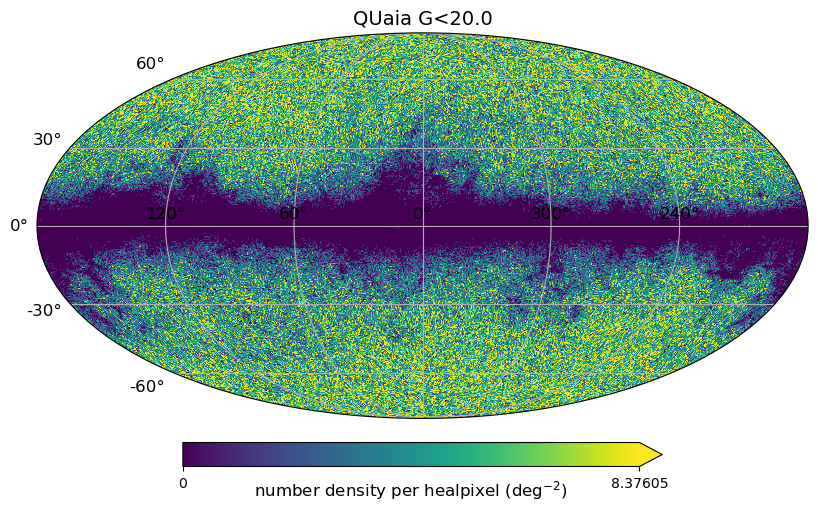

In [9]:
projview(map_data, title='QUaia G<20.0', projection_type='mollweide',
            unit=r"number density per healpixel (deg$^{-2}$)", coord=['C'], graticule=True, graticule_labels=True,
        min=minc, max=maxc)

### Compute dipole

In [10]:
# fit monopole and dipole:
map_data = [float(pix) for pix in map_data]  # need to convert all entries to floats to avoid error in remove_dipole()
map_nodip, monop, dip = hp.pixelfunc.remove_dipole(map_data, fitval=True)

In [11]:
# direction
lon, lat = hp.rotator.vec2dir(dip, lonlat=True)  # returns longitude and latitude in degrees
# amplitude
dipamp = np.linalg.norm(dip)
# create SkyCoord object
dip_quaia = SkyCoord(lon, lat, unit=u.deg, frame='galactic')

print(f"monopole: {monop:.6f}")
print(f"dipole: {dip}")
print(f"  dir ({lon:.3f}, {lat:.3f}), amplitude {dipamp:.6f}")

monopole: 3.844452
dipole: [-0.15280942 -0.18966379  0.21782923]
  dir (-128.858, 41.808), amplitude 0.326761


In [12]:
# dipoles computed from other surveys
dip_cmb = SkyCoord(264.021, 48.253, unit=u.deg, frame='galactic')
dip_wise21 = SkyCoord(238.2, 28.8, unit=u.deg, frame='galactic')
dip_wise23 = SkyCoord(237.2, 41.8, unit=u.deg, frame='galactic')

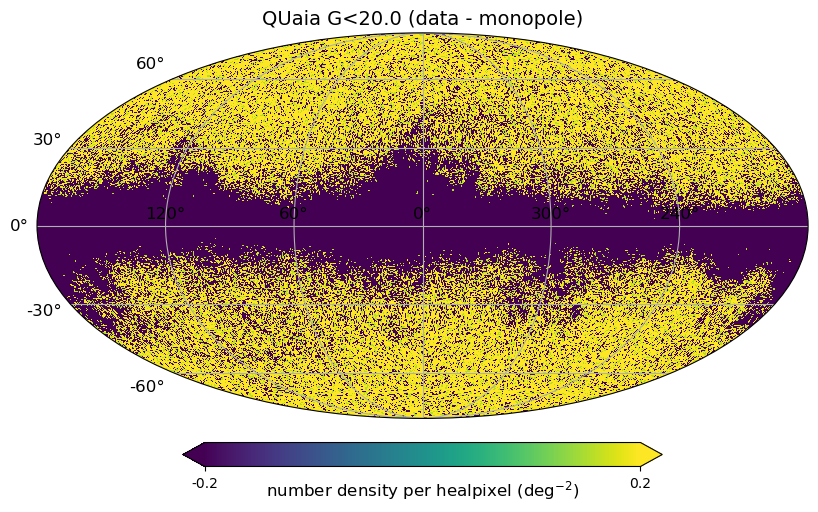

In [13]:
#minc = np.median(map_nodip)-1.5*np.std(map_nodip)
#maxc = np.median(map_nodip)+1.5*np.std(map_nodip)
projview(map_data-monop, title='QUaia G<20.0 (data - monopole)', projection_type='mollweide',
            unit=r"number density per healpixel (deg$^{-2}$)", coord=['C'], graticule=True, graticule_labels=True,
        min=-.2,max=0.2)

/ext3/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


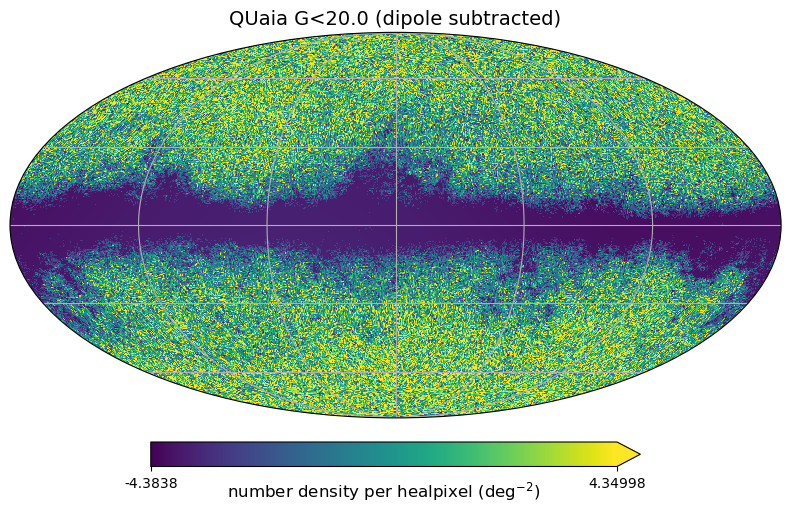

In [14]:
minc = np.median(map_nodip)-1.5*np.std(map_nodip)
maxc = np.median(map_nodip)+1.5*np.std(map_nodip)
projview(map_nodip, title='QUaia G<20.0 (dipole subtracted)', projection_type='mollweide',
            unit=r"number density per healpixel (deg$^{-2}$)", coord=['C'], graticule=True,
        min=minc, max=maxc)

In [15]:
dip_quaia

<SkyCoord (Galactic): (l, b) in deg
    (231.14210164, 41.8076501)>

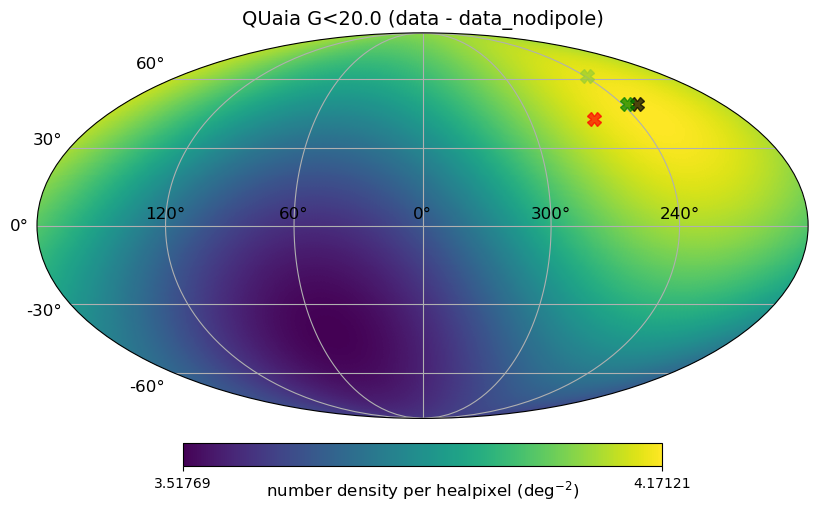

In [16]:
projview(map_data-map_nodip, title='QUaia G<20.0 (data - data_nodipole)', projection_type='mollweide',
            unit=r"number density per healpixel (deg$^{-2}$)", coord=['G'],
         graticule=True, graticule_labels=True, flip='astro')
# plot the dipole directions
# for some reason in this case theta<->latitude and phi<->longitude
m = "X"
ms = 10
a = 0.7
# QUaia, computed here
newprojplot(theta=dip_quaia.b.wrap_at(np.pi*u.radian).to('radian'), phi=dip_quaia.l.wrap_at(np.pi*u.radian).to('radian'),
            marker=m, color="k", alpha=a, markersize=ms)
# CMB
newprojplot(theta=dip_cmb.b.wrap_at(np.pi*u.radian).to('radian'), phi=dip_cmb.l.wrap_at(np.pi*u.radian).to('radian'),
            marker=m, color="r", alpha=a, markersize=ms)
# WISE
newprojplot(theta=dip_wise21.b.wrap_at(np.pi*u.radian).to('radian'), phi=dip_wise21.l.wrap_at(np.pi*u.radian).to('radian'),
            marker=m, color='yellowgreen', alpha=a, markersize=ms, label='WISE21')
newprojplot(theta=dip_wise23.b.wrap_at(np.pi*u.radian).to('radian'), phi=dip_wise23.l.wrap_at(np.pi*u.radian).to('radian'),
            marker=m, color='g', alpha=a, markersize=ms)

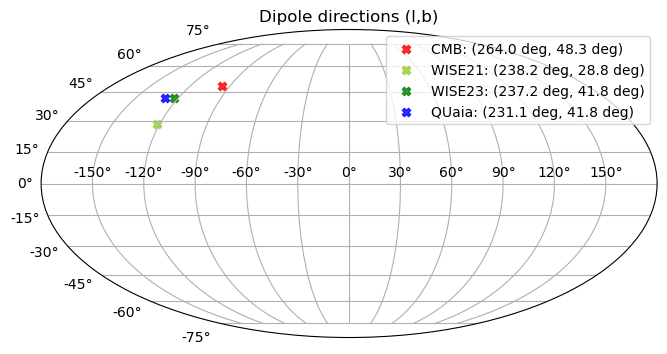

In [17]:
plt.figure(figsize=(8,4))
ax = plt.subplot(111, projection='mollweide')
plt.grid(True)

m = 'X'
plt.scatter(dip_cmb.l.wrap_at(np.pi*u.radian).to('radian'), dip_cmb.b.wrap_at(np.pi*u.radian).to('radian'),
           marker=m, c='r', alpha=0.8, label=f'CMB: ({dip_cmb.l:.1f}, {dip_cmb.b:.1f})')
plt.scatter(dip_wise21.l.wrap_at(np.pi*u.radian).to('radian'), dip_wise21.b.wrap_at(np.pi*u.radian).to('radian'),
           marker=m, c='yellowgreen', alpha=0.8, label=f'WISE21: ({dip_wise21.l:.1f}, {dip_wise21.b:.1f})')
plt.scatter(dip_wise23.l.wrap_at(np.pi*u.radian).to('radian'), dip_wise23.b.wrap_at(np.pi*u.radian).to('radian'),
           marker=m, c='g', alpha=0.8, label=f'WISE23: ({dip_wise23.l:.1f}, {dip_wise23.b:.1f})')
plt.scatter(dip_quaia.l.wrap_at(np.pi*u.radian).to('radian'), dip_quaia.b.wrap_at(np.pi*u.radian).to('radian'),
           marker=m, c='b', alpha=0.8, label=f'QUaia: ({dip_quaia.l:.1f}, {dip_quaia.b:.1f})')

plt.title('Dipole directions (l,b)')
ax.legend()

### Compare to random catalog

#### 1. Generate 3-vectors in (x,y,z)

In [18]:
rng = default_rng(seed=19)
rand_vecs = rng.normal(size=(nd,3))

#### 2. Convert $(x,y,z)\rightarrow (\mathrm{RA},\mathrm{ Dec})$

In [19]:
def xyz_to_thetaphi(xyz):
    x, y, z = xyz
    r = np.linalg.norm(xyz)
    theta = np.arctan2(y,x)
    phi = np.arccos(z/r)
    return theta, phi

def thetaphi_to_radec(theta, phi):
    ra = theta * 180/np.pi
    dec = 90 - phi * 180/np.pi
    return ra, dec

def xyz_to_radec(xyz):
    theta, phi = xyz_to_thetaphi(xyz)
    ra, dec = thetaphi_to_radec(theta, phi)
    return ra, dec

In [20]:
ra, dec = np.array([xyz_to_radec(pos) for pos in rand_vecs]).T

#### 3. Plot on the sky

In [21]:
# map of number counts
pix_idx_rand = hp.ang2pix(NSIDE, ra, dec, lonlat=True)
map_rand = np.bincount(pix_idx_rand, minlength=NPIX)

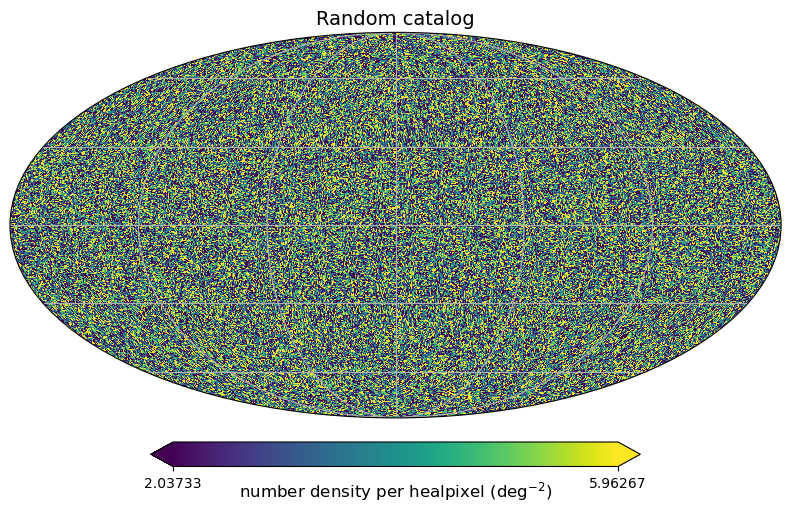

In [22]:
projview(map_rand, title='Random catalog', projection_type='mollweide',
            unit=r"number density per healpixel (deg$^{-2}$)", coord=['C'], graticule=True,
        min=np.median(map_rand)-np.std(map_rand), max=np.median(map_rand)+np.std(map_rand))

#### 4. Compute dipole

In [23]:
# fit monopole and dipole:
map_rand = [float(pix) for pix in map_rand]  # need to convert all entries to floats to avoid error in remove_dipole()
mapr_nodip, monopr, dipr = hp.pixelfunc.remove_dipole(map_rand, fitval=True)

In [24]:
# direction
lonr, latr = hp.rotator.vec2dir(dipr, lonlat=True)
# amplitude
dipampr = np.linalg.norm(dipr)
# create SkyCoord object
dip_rand = SkyCoord(lonr, latr, unit=u.deg, frame='galactic')

print(f"monopole: {monopr:.6f}")
print(f"dipole: {dipr}")
print(f"  dir ({lonr:.3f}, {latr:.3f}), amplitude {dipampr:.6f}")

monopole: 3.844452
dipole: [-0.00640519  0.00464446  0.00044501]
  dir (144.054, 3.219), amplitude 0.007924


### Compare QUaia to random results

In [25]:
# relative dipole amplitude
rel_dipamp = dipamp/dipampr
print(f"QUaia dipole is {rel_dipamp:.2f}x larger than random cat. dipole")

QUaia dipole is 41.23x larger than random cat. dipole


### Compare different NSIDE

NSIDE:  8
monopole: 984.179688
dipole: [-39.19940795 -48.36129943  55.83351218]
  dir (-129.027, 41.888), amplitude 83.622903

NSIDE:  32
monopole: 61.511230
dipole: [-2.44786258 -3.03559475  3.48540619]
  dir (-128.882, 41.790), amplitude 5.230193

NSIDE:  64
monopole: 15.377808
dipole: [-0.61132374 -0.7587882   0.87147045]
  dir (-128.857, 41.808), amplitude 1.307263

NSIDE:  128
monopole: 3.844452
dipole: [-0.15280942 -0.18966379  0.21782923]
  dir (-128.858, 41.808), amplitude 0.326761

NSIDE:  256
monopole: 0.961113
dipole: [-0.03819529 -0.04740302  0.05445928]
  dir (-128.860, 41.815), amplitude 0.081681

NSIDE:  512
monopole: 0.240278
dipole: [-0.00954873 -0.01185006  0.013614  ]
  dir (-128.862, 41.815), amplitude 0.020419



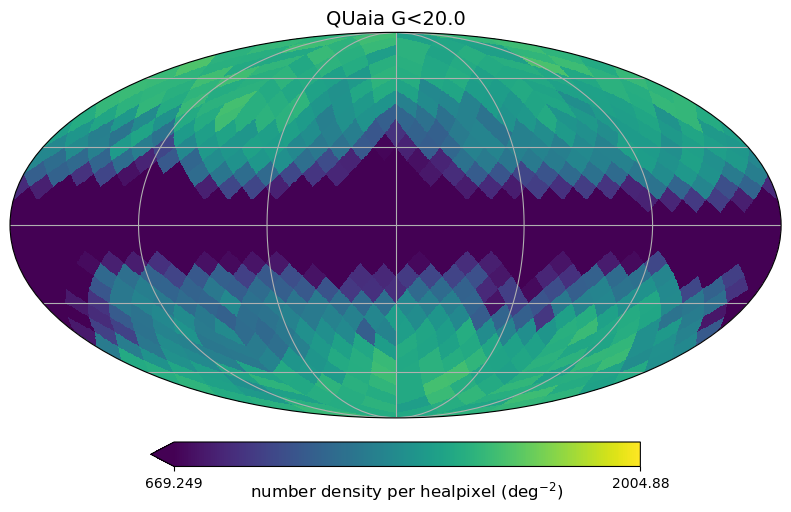

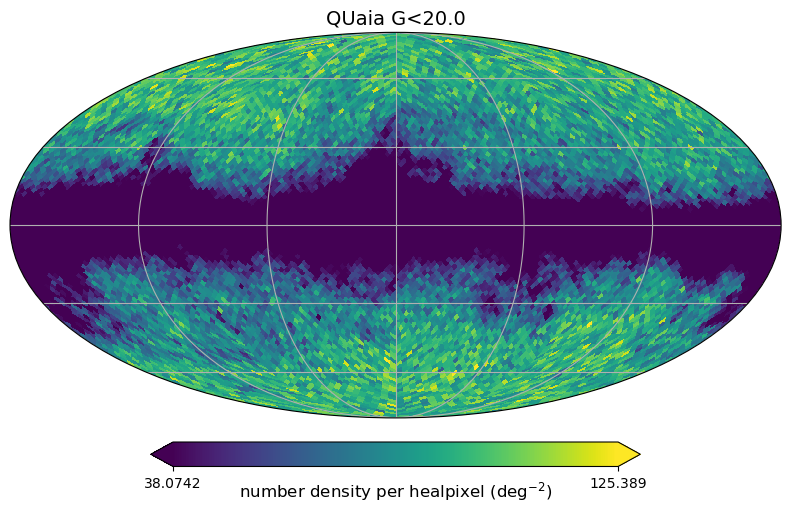

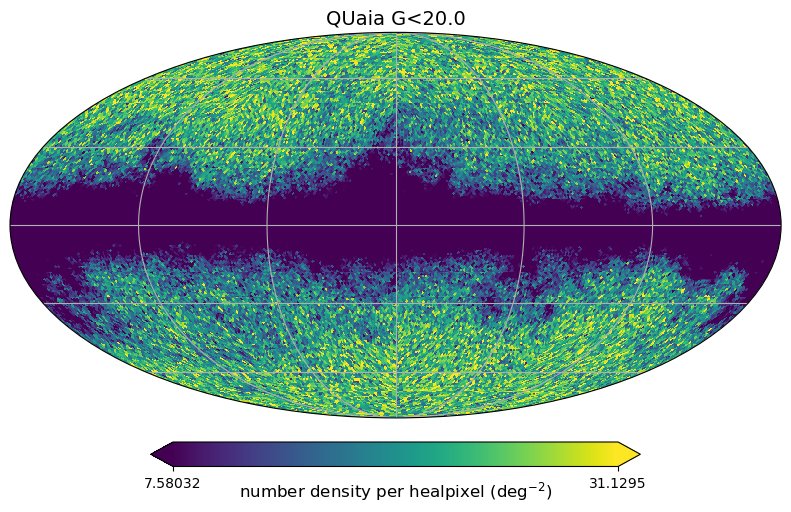

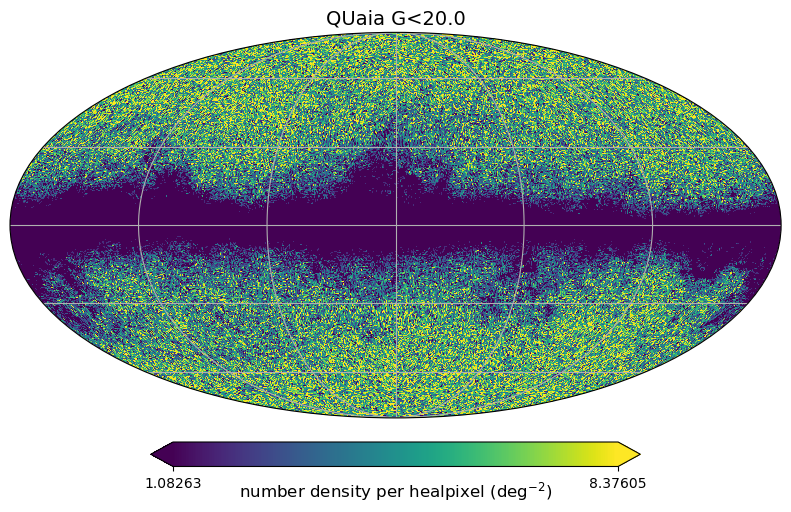

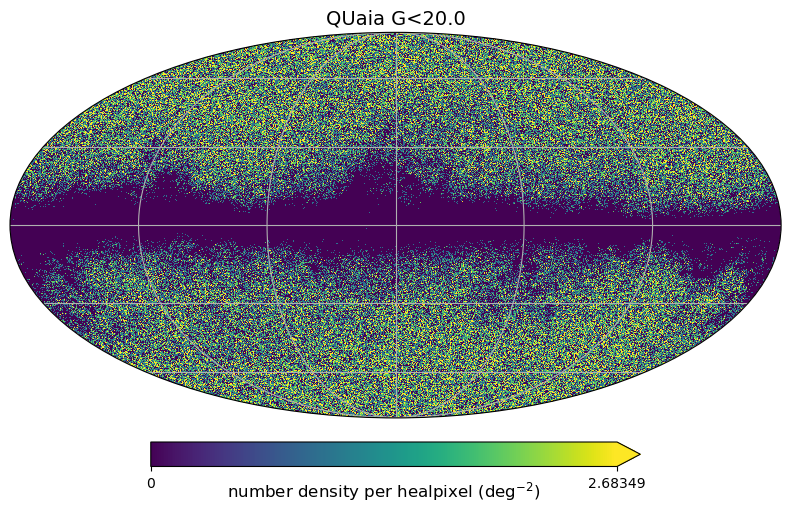

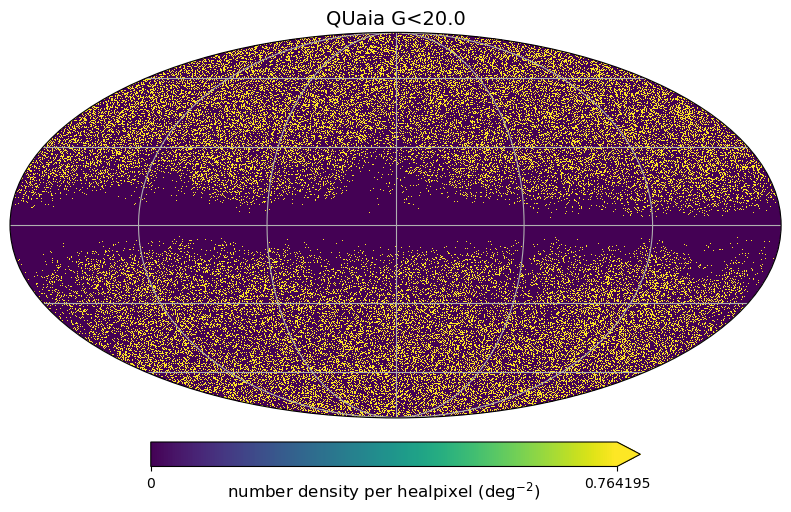

In [26]:
NSIDES = [8,32,64,128,256,512]
NPIXS = np.empty(len(NSIDES))
monops = np.empty(len(NSIDES))
dipamps = np.empty(len(NSIDES))
dipdirs = np.empty((len(NSIDES),2))
for i, NSIDE in enumerate(NSIDES):
    print("NSIDE: ",NSIDE)
    NPIX = hp.nside2npix(NSIDE)
    NPIXS[i] = NPIX
    # format (l,b) from loaded QUaia catalog into healpy map
    pix_idx = hp.ang2pix(NSIDE, l, b, lonlat=True)
    map_data = np.bincount(pix_idx, minlength=NPIX)
    # plot to check that NSIDE looks right
    minc = max((np.median(map_data)-np.std(map_data),0))
    maxc = np.median(map_data)+1.5*np.std(map_data)
    projview(map_data, title='QUaia G<20.0', projection_type='mollweide',
            unit=r"number density per healpixel (deg$^{-2}$)", coord=['C'], graticule=True,
        min=minc, max=maxc)
    # fit monopole and dipole:
    map_data = [float(pix) for pix in map_data]  # need to convert all entries to floats to avoid error in remove_dipole()
    map_nodip, monop, dip = hp.pixelfunc.remove_dipole(map_data, fitval=True)
    monops[i] = monop
    # direction
    lon, lat = hp.rotator.vec2dir(dip, lonlat=True)
    dipdirs[i] = lon, lat
    # amplitude
    dipamp = np.linalg.norm(dip)
    dipamps[i] = dipamp
    # print results
    print(f"monopole: {monop:.6f}")
    print(f"dipole: {dip}")
    print(f"  dir ({lon:.3f}, {lat:.3f}), amplitude {dipamp:.6f}")
    print("")

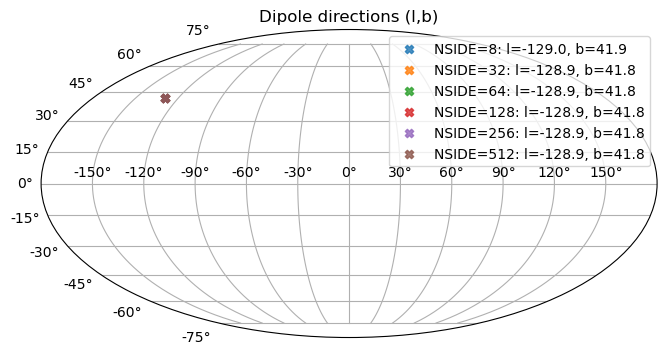

In [27]:
# plot directions
plt.figure(figsize=(8,4))
ax = plt.subplot(111, projection='mollweide')
plt.grid(True)
m = 'X'

for i, dipdir in enumerate(dipdirs):
    l, b = dipdir
    thisdip = SkyCoord(l, b, unit=u.deg, frame='galactic')
    plt.scatter(thisdip.l.wrap_at(np.pi*u.radian).to('radian'), thisdip.b.wrap_at(np.pi*u.radian).to('radian'),
           marker=m, alpha=0.8, label=f'NSIDE={NSIDES[i]}: l={l:.1f}, b={b:.1f}')

plt.title('Dipole directions (l,b)')
ax.legend()

In [28]:
dipamps

array([8.36229033e+01, 5.23019340e+00, 1.30726316e+00, 3.26760840e-01,
       8.16807181e-02, 2.04191860e-02])

In [29]:
# fit a power law
poptlog, dipampfit = curve_fit_log(NSIDES, dipamps)
poptlog

array([ 8.58554919, -2.00000578])

In [30]:
# -2
y = np.array([NSIDE**(-2) for NSIDE in NSIDES])

Text(0.5, 0.98, 'Relation between NSIDE/NPIX and dipole amplitude')

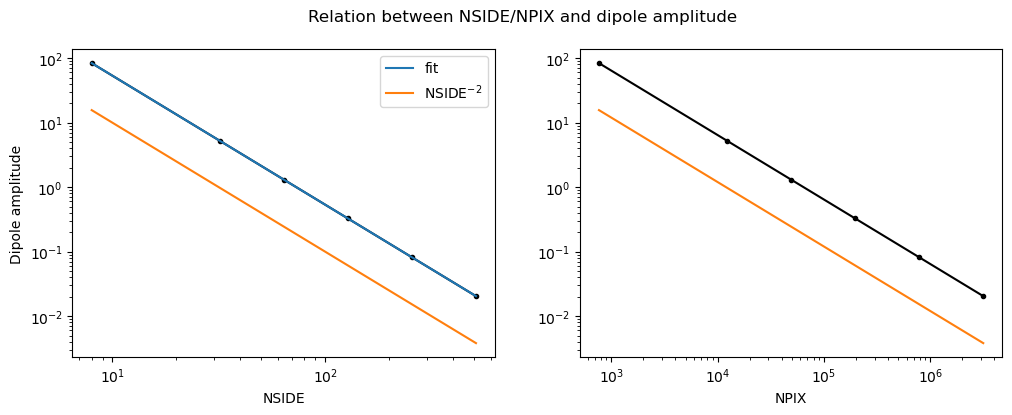

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))

axs[0].plot(NSIDES, dipamps, 'k.-')
axs[0].plot(NSIDES, dipampfit, c='C0', label='fit')
axs[0].plot(NSIDES, y*10**3, c='C1', label='NSIDE$^{-2}$')
axs[0].set_xlabel('NSIDE')
axs[0].set_ylabel('Dipole amplitude')
axs[0].legend()

axs[1].plot(NPIXS, dipamps, 'k.-')
axs[1].plot(NPIXS, y*10**3, c='C1', label='NPIX$^{-2}$')
axs[1].set_xlabel('NPIX')

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
fig.suptitle('Relation between NSIDE/NPIX and dipole amplitude')

In [33]:
for i in range(len(NSIDES)):
    print(dipamps[i]/monops[i])

0.08496710947557051
0.08502826819797984
0.08500972288993335
0.08499542942163942
0.08498555337947324
0.08498141832718295
